In [54]:
import torch
from torch import nn
from d2l import torch as d2l
from torchvision import transforms
import torchvision

In [55]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):  #moving_mean和moving_var是全局均值和方差
    if not torch.is_grad_enabled():
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:
            mean=X.mean(dim=0,keepdim=True)
            var=((X-mean)**2).mean(dim=0,keepdim=True)
        else:
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat=(X-mean)/torch.sqrt(var+eps)
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta
    return Y, moving_mean.data, moving_var.data

In [56]:
#创建一个BN的图层
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
    def forward(self,X):
        if self.moving_mean.device!=X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_mean.to(X.device)
        Y,self.moving_mean,self.moving_var=batch_norm(X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
        return Y

In [57]:
#应用BatchNorm在LeNet中
lenet=nn.Sequential(nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
                    nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
                    nn.Flatten(),nn.Linear(16*4*4,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),nn.Linear(120,84),BatchNorm(84,num_dims=2),
                    nn.Sigmoid(),nn.Linear(84,10)
                   )

In [58]:
#加载数据集
#加载数据集
batch_size=256
trans=transforms.ToTensor()
train_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=True,transform=trans,download=False)
test_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=False,transform=trans,download=False)
train_iter=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2)
test_iter=torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=False,num_workers=2)

loss 0.214, train acc 0.921, test acc 0.887
28756.3 examples/sec on cuda:0


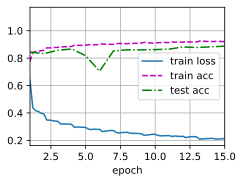

In [59]:
lr,num_epochs=1.0,15
d2l.train_ch6(lenet,train_iter,test_iter,num_epochs,lr,'cuda:0')

In [60]:
lenet[1].gamma.reshape((-1,)),lenet[1].beta.reshape((-1,))

(tensor([1.8875, 1.8135, 2.6847, 2.2231, 2.1929, 2.2438], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.1455, -2.0997,  0.0655, -2.7277, -0.3589, -1.9225], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [61]:
#简洁实现
# 简洁使用
lenet = nn.Sequential(nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),
                   nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
                   nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),
                   nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
                   nn.Flatten(),nn.Linear(256,120),nn.BatchNorm1d(120),
                   nn.Sigmoid(),nn.Linear(120,84),nn.BatchNorm1d(84),
                   nn.Sigmoid(),nn.Linear(84,10))

loss 0.214, train acc 0.921, test acc 0.884
38272.2 examples/sec on cuda:0


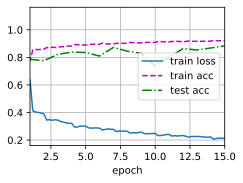

In [63]:
# 使用相同超参数来训练模型
d2l.train_ch6(lenet, train_iter, test_iter, num_epochs, lr, 'cuda:0')